In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Group Image')

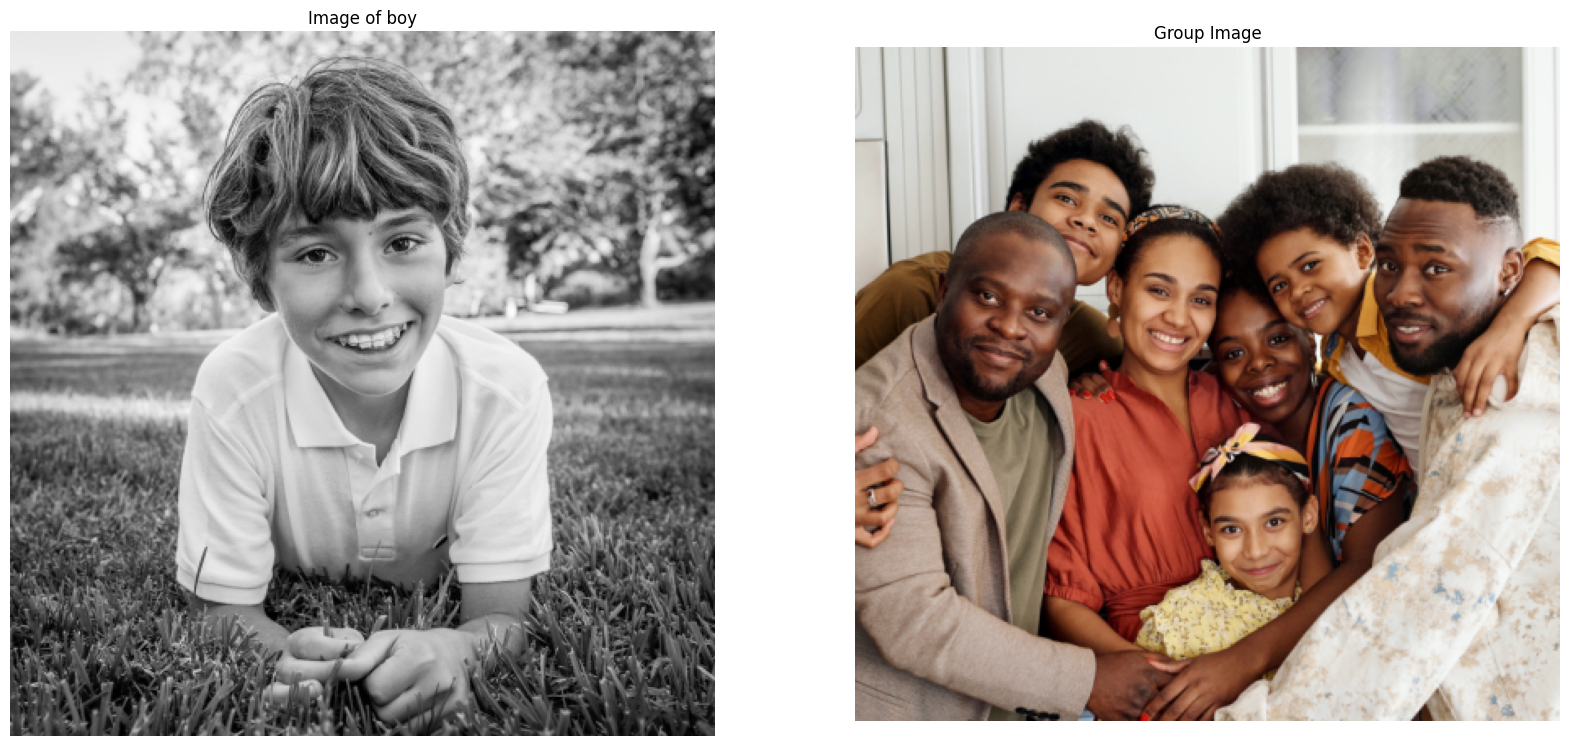

In [2]:
img1 = cv2.imread('../Applications/boy.jpg', cv2.IMREAD_COLOR)
img2 = cv2.imread('../Applications/family.jpg',cv2.IMREAD_COLOR)

fig = plt.figure(figsize=(20,10))

plt.subplot(121);plt.axis('off');plt.imshow(img1[:,:,::-1]);plt.title("Image of boy")
plt.subplot(122);plt.axis('off');plt.imshow(img2[:,:,::-1]);plt.title("Group Image")

In [3]:
modelFile = '../model/res10_300x300_ssd_iter_140000.caffemodel'
configFile = '../model/deploy.prototxt'

net = cv2.dnn.readNetFromCaffe(prototxt=configFile, caffeModel = modelFile)

In [4]:
def blur(face, factor=3):
    h,w = face.shape[:2]

    if factor < 1: factor = 1
    if factor > 5: factor = 5

    w_k = int(w/factor)
    h_k = int(h/factor)

    if w_k % 2 == 0 : w_k += 1
    if h_k % 2 == 0 : h_k += 1

    blurred = cv2.GaussianBlur(face,(int(w_k),int(h_k)),0,0)

    return blurred

In [5]:
def face_blur_rect(image, net, factor = 3, detection_threshold = 0.9 ):
    img = image.copy()
    blob = cv2.dnn.blobFromImage(img, scalefactor = 1.0, size=(300,300), mean=[104, 117, 123])
    net.setInput(blob)
    detections = net.forward()

    (h,w) = img.shape[:2]

    for i in range(detections.shape[2]):
        confidence = detections[0,0,i,2]
        if confidence > detection_threshold:
            box = detections[0,0,i,3:7] * np.array([w,h,w,h])
            (x1,y1,x2,y2) = box.astype("int")
            face = img[y1:y2,x1:x2]
            face = blur(face,factor=factor)
            img[y1:y2,x1:x2] = face
    return img

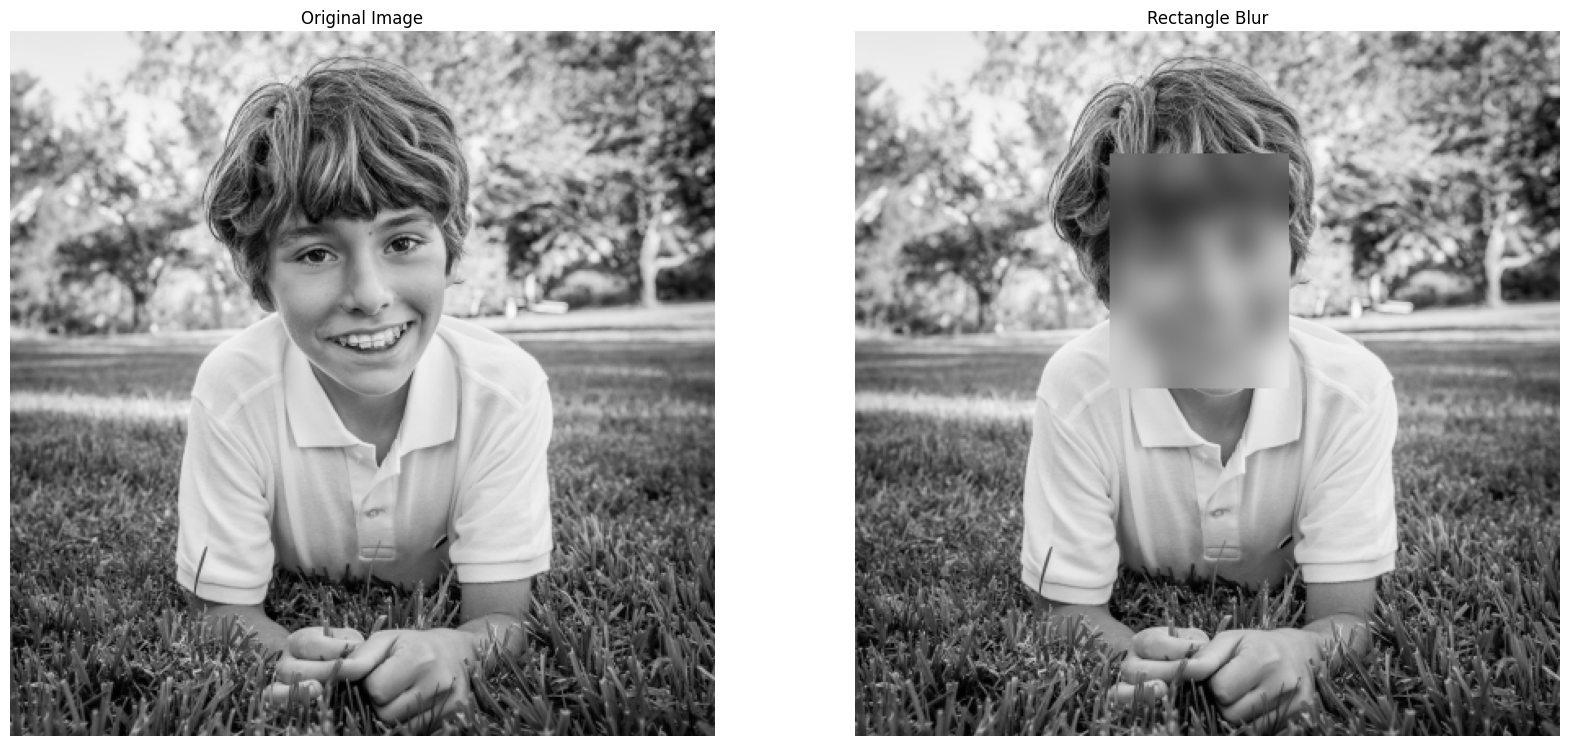

In [6]:
img1_rect = face_blur_rect(img1,net,factor=2.5)

figure = plt.figure(figsize=(20,10))

plt.subplot(121);plt.axis('off');plt.imshow(img1[:,:,::-1]);plt.title("Original Image")
plt.subplot(122);plt.axis('off');plt.imshow(img1_rect[:,:,::-1]);plt.title("Rectangle Blur")
plt.show()

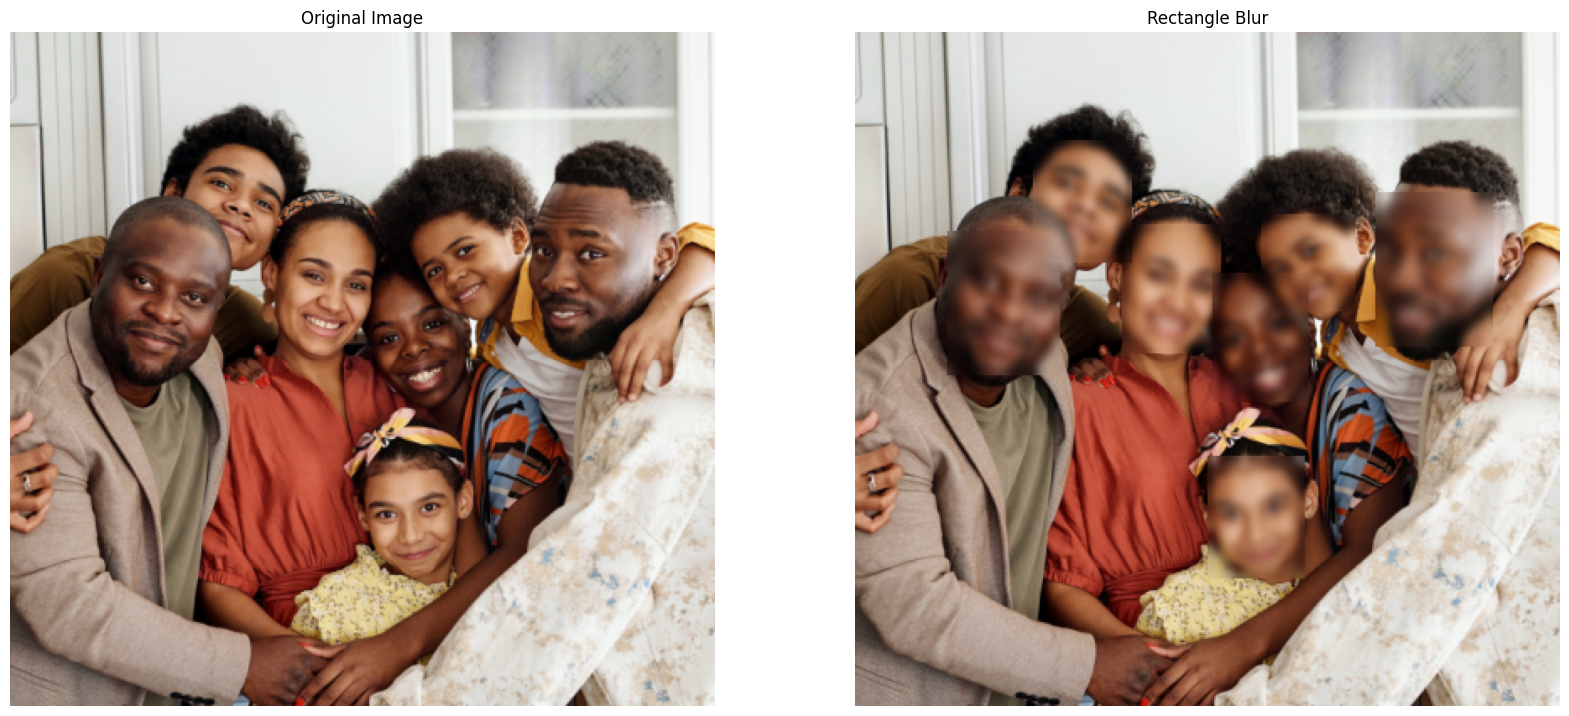

In [9]:
img2_rect = face_blur_rect(img2,net,factor=5)

figure = plt.figure(figsize=(20,10))

plt.subplot(121);plt.axis('off');plt.imshow(img2[:,:,::-1]);plt.title("Original Image")
plt.subplot(122);plt.axis('off');plt.imshow(img2_rect[:,:,::-1]);plt.title("Rectangle Blur")
plt.show()

In [23]:
def face_blur_ellipse(image, net, factor = 3, detect_threshold= 0.90, write_mask = False):
    img = image.copy()
    img_blur = image.copy()

    elliptical_mask = np.zeros(img.shape, dtype = img.dtype)
    blob = cv2.dnn.blobFromImage(img, scalefactor = 1.0, size=(300,300), mean=[104, 117, 123])
    net.setInput(blob)
    detections = net.forward()

    (h,w) = img.shape[:2]

    for i in range(detections.shape[2]):
        confidence = detections[0,0,i,2]
        if confidence > detect_threshold:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box
            face = img[int(y1):int(y2), int(x1):int(x2), :]
           
            # Blur the rectangular area defined by the bounding box.
            face = blur(face, factor=factor)

            # Copy the `blurred_face` to the blurred image.
            img_blur[int(y1):int(y2), int(x1):int(x2), :] = face
            
            # Specify the elliptical parameters directly from the bounding box coordinates.
            e_center = (x1 + (x2 - x1)/2, y1 + (y2 - y1)/2)
            e_size   = (x2 - x1, y2 - y1)
            e_angle  = 0.0
            
            # Create an elliptical mask. 
            elliptical_mask = cv2.ellipse(elliptical_mask, (e_center, e_size, e_angle), 
                                                      (255, 255, 255), -1, cv2.LINE_AA)  
            # Apply the elliptical mask
            np.putmask(img, elliptical_mask, img_blur)
            np.putmask(img, elliptical_mask, img_blur)

    if write_mask:
        cv2.imwrite("elliptical_mask.jpg",elliptical_mask)
    return img 

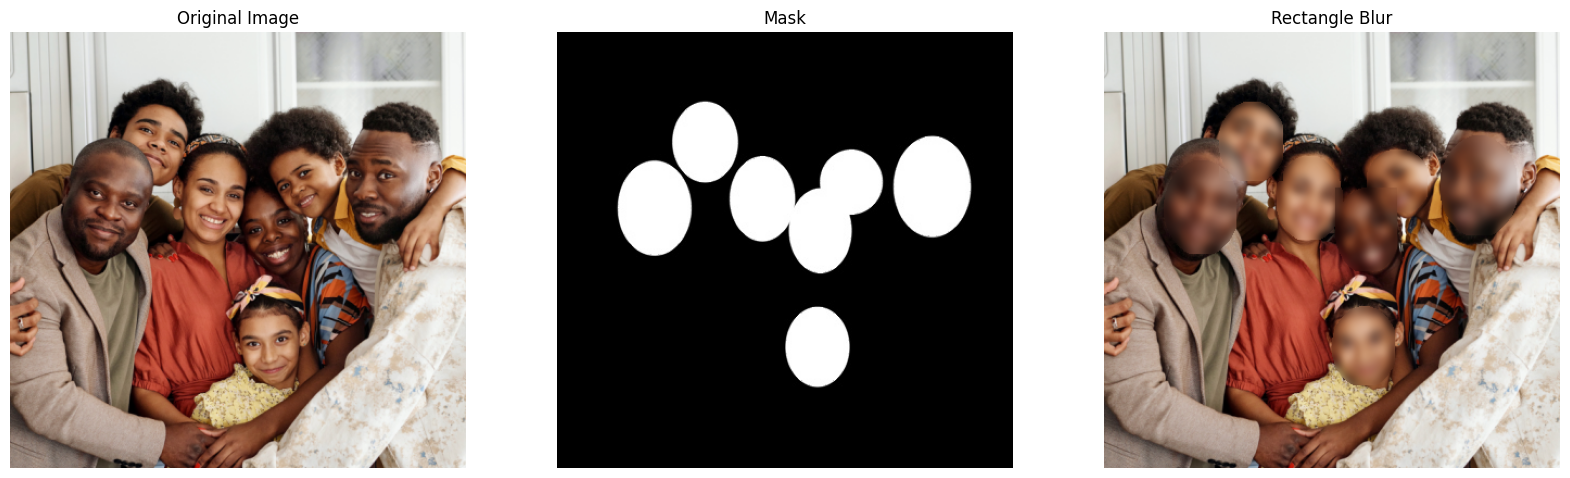

In [24]:
img2_ellipse = face_blur_ellipse(img2,net,factor=3,write_mask=True)

figure = plt.figure(figsize=(20,10))
mask = cv2.imread('elliptical_mask.jpg')
plt.subplot(131);plt.axis('off');plt.imshow(img2[:,:,::-1]);plt.title("Original Image")
plt.subplot(132);plt.axis('off');plt.imshow(mask);plt.title("Mask")
plt.subplot(133);plt.axis('off');plt.imshow(img2_ellipse[:,:,::-1]);plt.title("Rectangle Blur")
plt.show()

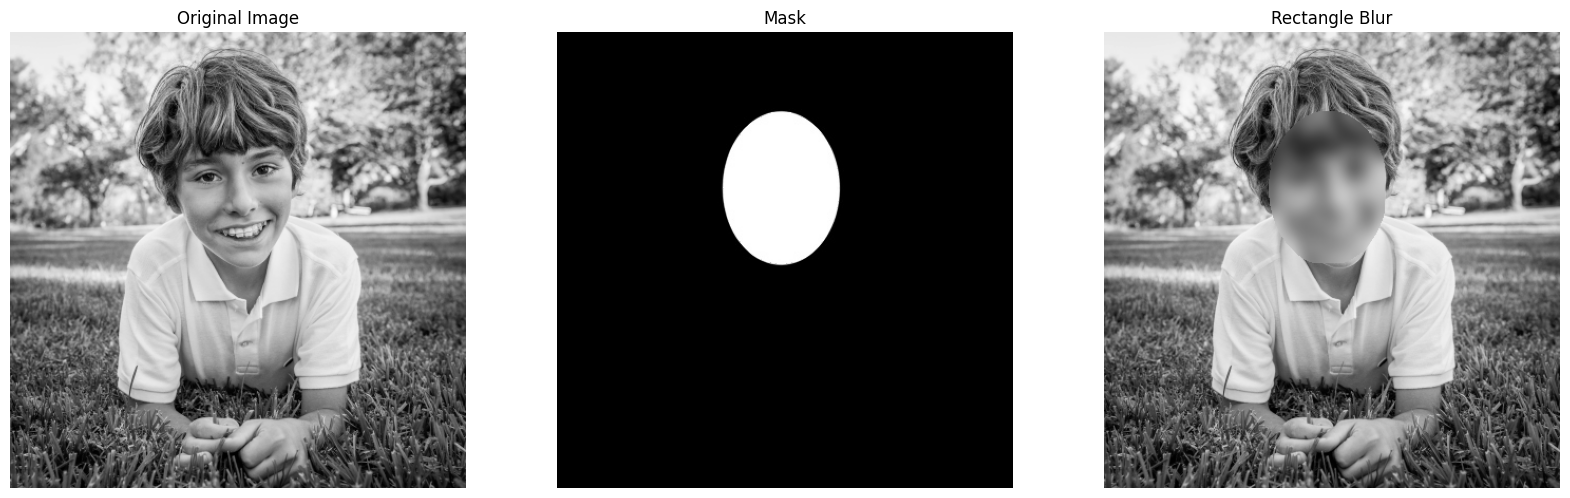

In [25]:
img1_ellipse = face_blur_ellipse(img1,net,factor=3,write_mask=True)

figure = plt.figure(figsize=(20,10))
mask = cv2.imread('elliptical_mask.jpg')
plt.subplot(131);plt.axis('off');plt.imshow(img1[:,:,::-1]);plt.title("Original Image")
plt.subplot(132);plt.axis('off');plt.imshow(mask);plt.title("Mask")
plt.subplot(133);plt.axis('off');plt.imshow(img1_ellipse[:,:,::-1]);plt.title("Rectangle Blur")
plt.show()

In [27]:
def pixelate(roi, pixels = 16):
    roi_h, roi_w = roi.shape[:2]
    if roi_h > pixels and roi_w > pixels:
        roi_small = cv2.resize(roi, (pixels,pixels), interpolation = cv2.INTER_LINEAR)
        roi_pixelated = cv2.resize(roi_small, (roi_w, roi_h), interpolation = cv2.INTER_NEAREST)
    else:
        roi_pixelated = roi
    return roi_pixelated 

In [30]:
def face_pixelated(image, net, detection_threshold=0.9, pixels = 10):
    img = image.copy()

    blob = cv2.dnn.blobFromImage(img, scalefactor = 1.0 , size = (300,300), mean =[104, 117, 123])
    net.setInput(blob)
    detections = net.forward()

    h, w = img.shape[:2]

    for i in range(detections.shape[2]):
        confidence = detections[0,0,i,2]
        if confidence > detection_threshold:
            box = detections[0,0,i,3:7] * np.array([w,h,w,h])
            (x1,y1,x2,y2) = box.astype("int")
            face = img[y1:y2,x1:x2]
            face = pixelate(face, pixels = pixels)
            img[y1:y2,x1:x2] = face
    return img

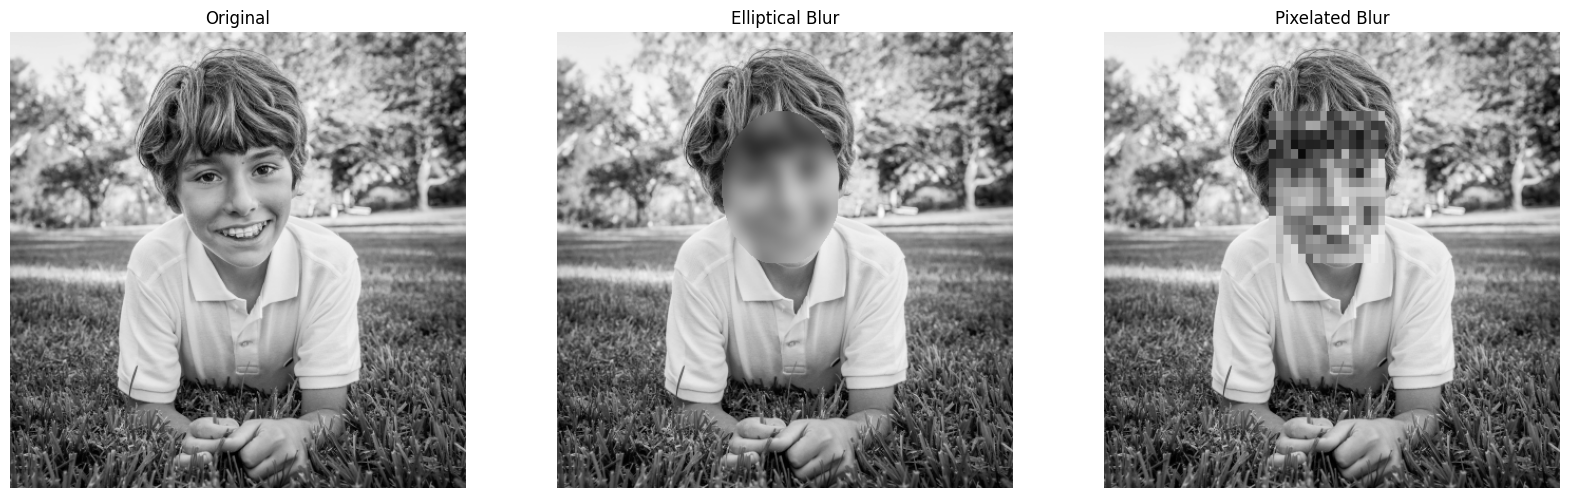

In [32]:
img1_pixel = face_pixelated(img1, net, pixels = 16)
plt.figure(figsize=(20,10))

plt.subplot(131);plt.axis('off');plt.imshow(img1[:,:,::-1]);plt.title("Original")
plt.subplot(132);plt.axis('off');plt.imshow(img1_ellipse[:,:,::-1]);plt.title("Elliptical Blur")
plt.subplot(133);plt.axis('off');plt.imshow(img_pixel[:,:,::-1]);plt.title("Pixelated Blur")
plt.show()

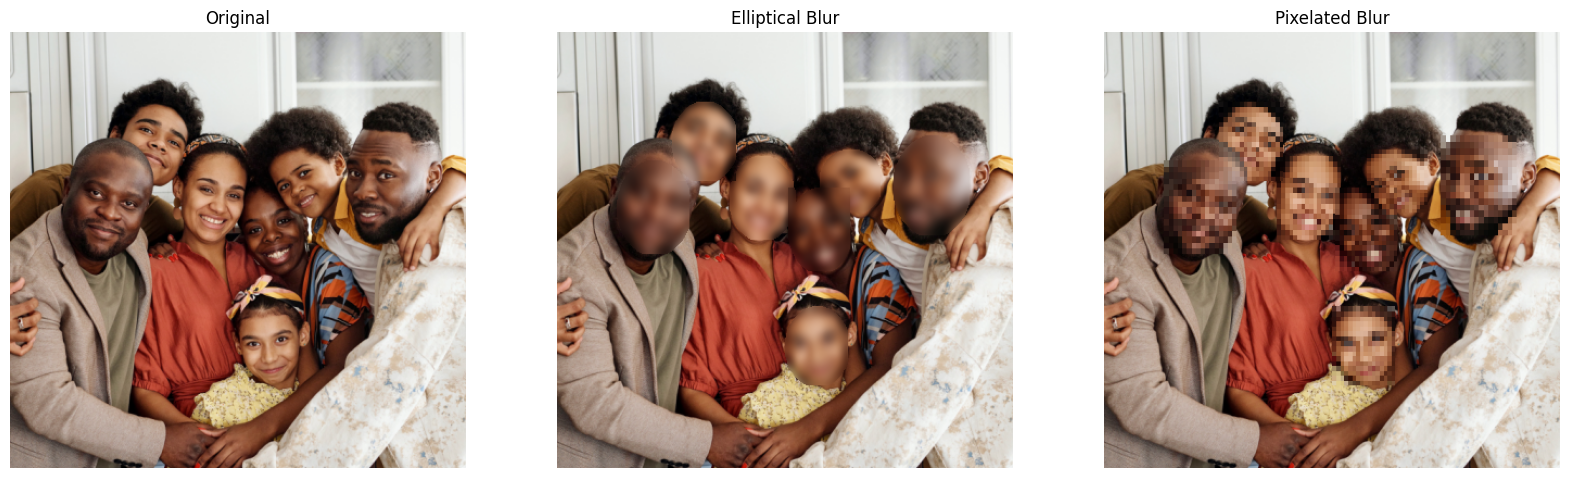

In [33]:
img2_pixel = face_pixelated(img2, net, pixels = 16)
plt.figure(figsize=(20,10))

plt.subplot(131);plt.axis('off');plt.imshow(img2[:,:,::-1]);plt.title("Original")
plt.subplot(132);plt.axis('off');plt.imshow(img2_ellipse[:,:,::-1]);plt.title("Elliptical Blur")
plt.subplot(133);plt.axis('off');plt.imshow(img2_pixel[:,:,::-1]);plt.title("Pixelated Blur")
plt.show()

In [39]:
def face_blur_ellipse_pixelate(image, net, detection_threshold=0.9, factor = 3, pixels = 10, write_mask = True):
    img = image.copy()
    img_out = img.copy()
    elliptical_mask = np.zeros(img.shape, dtype = img.dtype)
    h,w = img.shape[:2]

    blob = cv2.dnn.blobFromImage(img, scalefactor = 1.0, size=(300,300), mean = [104, 117, 123])
    net.setInput(blob)
    detections = net.forward()
    for i in range(detections.shape[2]):
        confidence = detections[0,0,i,2]
        if confidence > detection_threshold:
            box = detections[0,0,i,3:7] * np.array([w,h,w,h])
            (x1,y1,x2,y2) = box
            face = img[int(y1):int(y2),int(x1):int(x2),:]
            face = blur(face, factor = factor)
            face = pixelate(face, pixels = pixels)
            img_out[int(y1):int(y2),int(x1):int(x2),:] = face

            e_center = (x1 + (x2 - x1) / 2 , y1 + (y2 - y1) / 2)
            e_size= (x2 - x1, y2 - y1)
            e_angle = 0.0

            elliptical_mask = cv2.ellipse(elliptical_mask, (e_center, e_size, e_angle), (255, 255, 255), -1 , cv2.LINE_AA)
            np.putmask(img,elliptical_mask,img_out)

    if write_mask:
        cv2.imwrite("elliptical_mask.jpg",elliptical_mask)
    return img
            

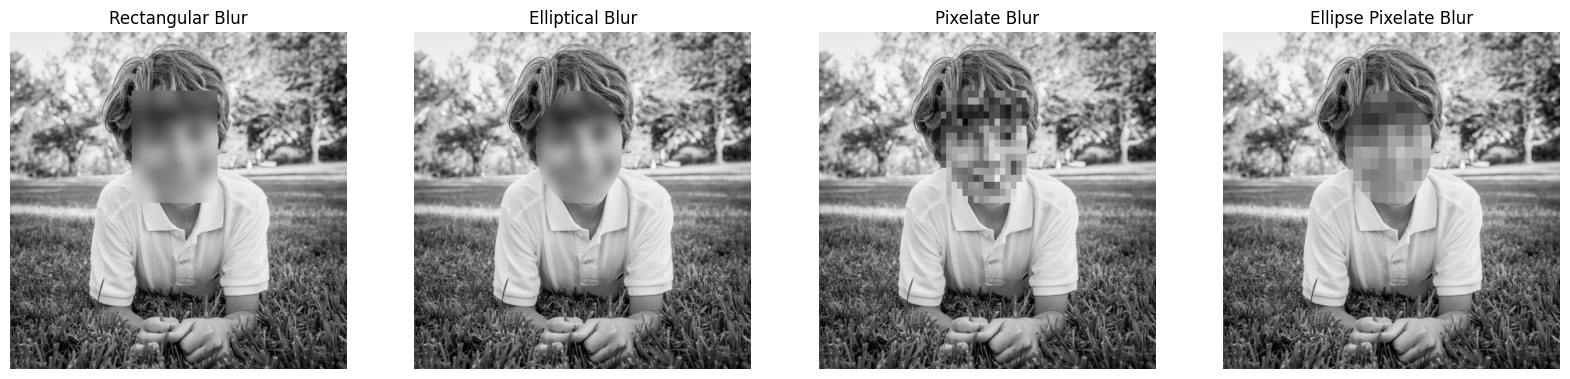

In [40]:
img1_epb = face_blur_ellipse_pixelate(img1, net)

plt.figure(figsize=(20,10))
plt.subplot(141);plt.axis('off');plt.imshow(img1_rect[:,:,::-1]);plt.title("Rectangular Blur")
plt.subplot(142);plt.axis('off');plt.imshow(img1_ellipse[:,:,::-1]);plt.title("Elliptical Blur")
plt.subplot(143);plt.axis('off');plt.imshow(img1_pixel[:,:,::-1]);plt.title("Pixelate Blur")
plt.subplot(144);plt.axis('off');plt.imshow(img1_epb[:,:,::-1]);plt.title("Ellipse Pixelate Blur")
plt.show()

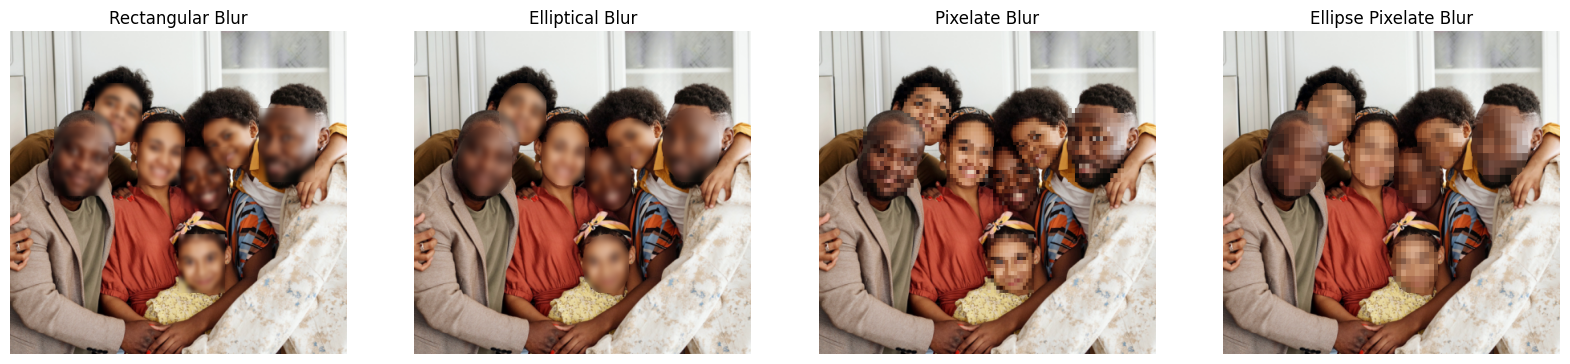

In [41]:
img2_epb = face_blur_ellipse_pixelate(img2, net)

plt.figure(figsize=(20,10))
plt.subplot(141);plt.axis('off');plt.imshow(img2_rect[:,:,::-1]);plt.title("Rectangular Blur")
plt.subplot(142);plt.axis('off');plt.imshow(img2_ellipse[:,:,::-1]);plt.title("Elliptical Blur")
plt.subplot(143);plt.axis('off');plt.imshow(img2_pixel[:,:,::-1]);plt.title("Pixelate Blur")
plt.subplot(144);plt.axis('off');plt.imshow(img2_epb[:,:,::-1]);plt.title("Ellipse Pixelate Blur")
plt.show()